## Import dataset

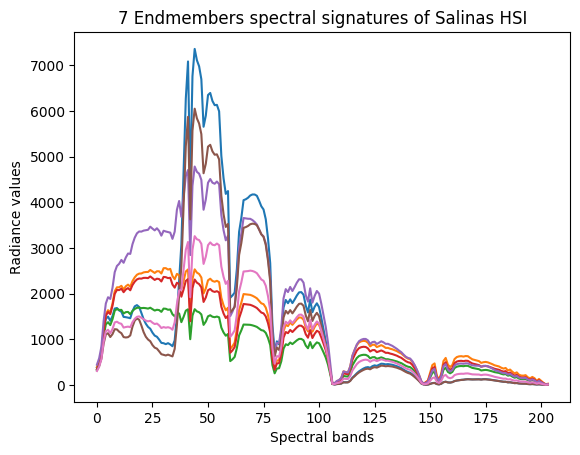

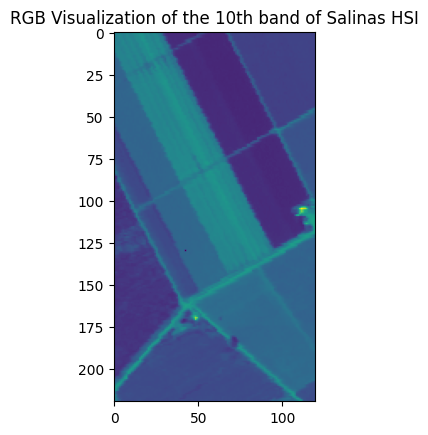

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import scipy.optimize 
import matplotlib.pyplot as plt
import seaborn as sns
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()

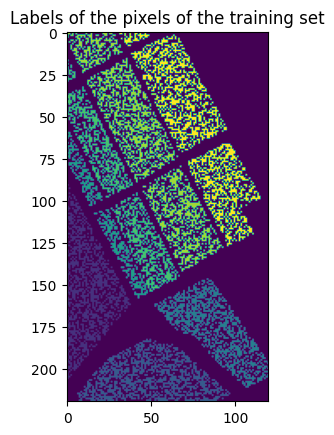

In [2]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

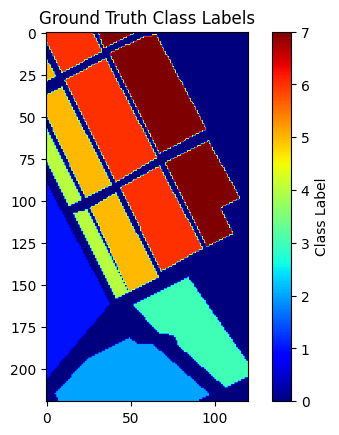

In [3]:
# Visualize the class labels 
plt.imshow(labels, cmap='jet')
plt.colorbar(label='Class Label')
plt.title('Ground Truth Class Labels')
plt.show()

# Part 1

## 1) Least squares simple

In [4]:
import numpy as np

theta_hat_1 = np.zeros((HSI.shape[0], HSI.shape[1], 7), dtype=np.float64)

for i in range(HSI.shape[0]):
    for j in range(HSI.shape[1]):
      X = endmembers
      y = HSI[i,j,:]

      # Calculate the least squares estimate for theta
      theta_hat_1[i,j] = np.linalg.inv(X.T @ X) @ X.T @ y



In [5]:
y_pred_1=np.zeros((HSI.shape), dtype=np.float64)

for band in range(y_pred_1.shape[2]):
    for i in range(y_pred_1.shape[0]):
       for j in range(y_pred_1.shape[1]):
        y_pred_1[i,j,band]=(X @ theta_hat_1[i,j])[band]

In [6]:
rec_error_1=0
diff_square_1=0
cnt_1=0

for i in range(HSI.shape[0]):
    for j in range(HSI.shape[1]):
        for k in range(HSI.shape[2]):
            diff_square_1= diff_square_1 + ((HSI[i,j,k]-y_pred_1[i,j,k])**2)
            cnt_1 = cnt_1 + 1

rec_error_1 = diff_square_1/cnt_1
print('Reconstruction error for the first method is:',{rec_error_1})

Reconstruction error for the first method is: {748.5775902929545}


C:\Users\User\AppData\Local\Temp\ipykernel_13468\3732890888.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


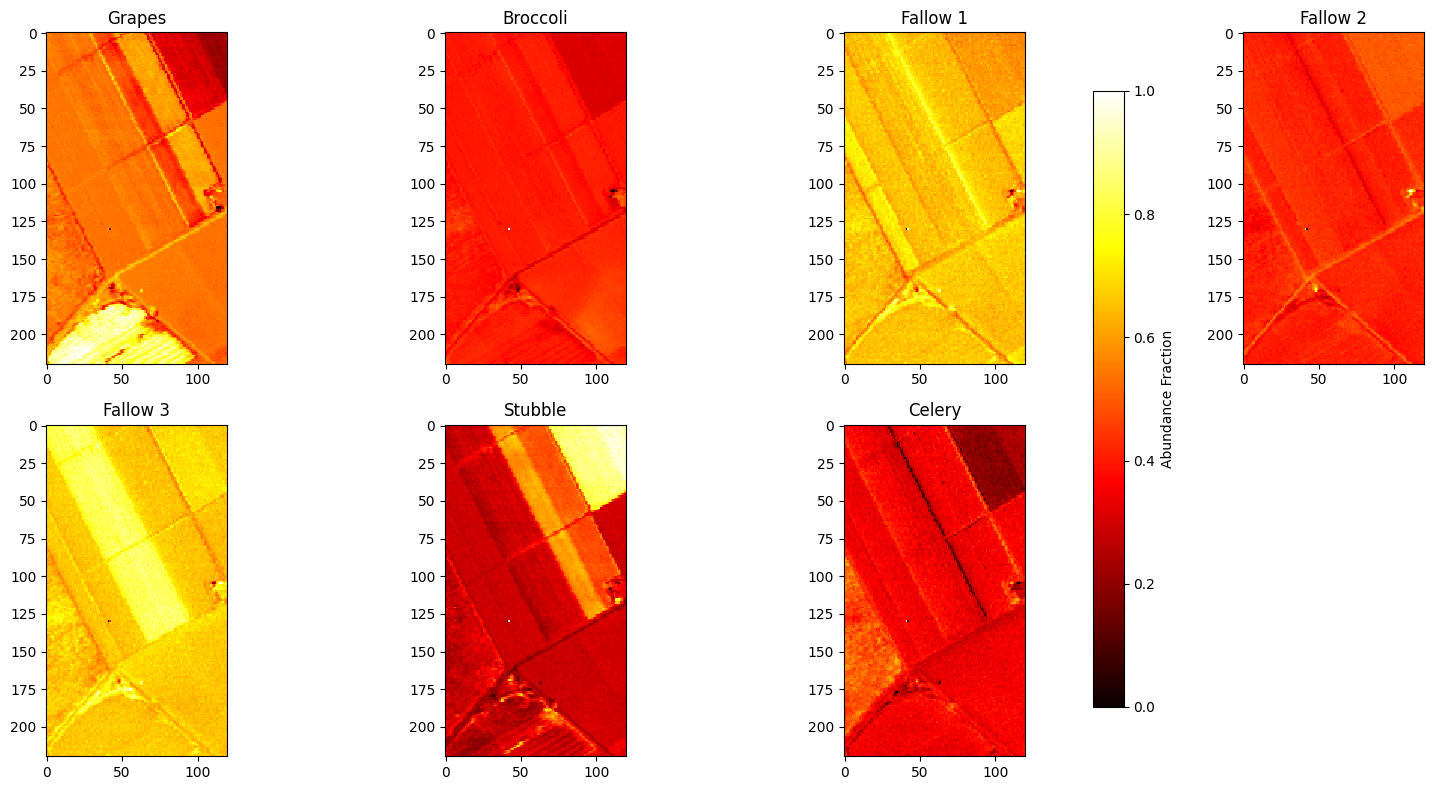

In [7]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable


fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Abundance map for each material
abundance_maps = [theta_hat_1[:, :, i] for i in range(7)]

# Plot abundance maps for each material
titles = ['Grapes', 'Broccoli', 'Fallow 1', 'Fallow 2', 'Fallow 3', 'Stubble', 'Celery']
for i, ax in enumerate(axes.flatten()):
    if i < len(abundance_maps):
        im = ax.imshow(abundance_maps[i], cmap='hot', interpolation='nearest')
        ax.set_title(titles[i])
        ax.set_aspect('equal')  # Equal aspect ratio for better visualization
    else:
        ax.axis('off')  # hide empty subplot

# Normalize colorbar with range 0 to 1
norm = plt.Normalize(vmin=0, vmax=1)  
sm = ScalarMappable(cmap='hot', norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=axes, label='Abundance Fraction')

plt.tight_layout()
plt.show()


## 2) Least squares imposing the sum-to-one constraint 

In [8]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function for least squares
def least_squares_obj(theta, X, y):
    return np.linalg.norm(X.dot(theta) - y)**2

# Define the constraint function for sum-to-one constraint
def sum_to_one_constraint(theta):
    return np.sum(theta) - 1

# Initialize theta_hat_2 with the correct shape and data type
theta_hat_2 = np.zeros((HSI.shape[0], HSI.shape[1], 7), dtype=np.float64)

# Define the vector of ones
ones_vector = np.ones((7,))

for i in range(HSI.shape[0]):
    for j in range(HSI.shape[1]):
        X = endmembers
        y = HSI[i, j, :]

        # Solve the constrained least squares problem
        result = minimize(least_squares_obj, x0=np.zeros(7), args=(X, y), constraints={'type': 'eq', 'fun': sum_to_one_constraint})

        # Store the estimated parameter vector
        theta_hat_2[i, j] = result.x


In [9]:
y_pred_2=np.zeros((HSI.shape), dtype=np.float64)

for band in range(y_pred_2.shape[2]):
    for i in range(y_pred_2.shape[0]):
       for j in range(y_pred_2.shape[1]):
        y_pred_2[i,j,band]=(X @ theta_hat_2[i,j])[band]

In [10]:
rec_error_2=0
diff_square_2=0
cnt_2=0

for i in range(HSI.shape[0]):
    for j in range(HSI.shape[1]):             
        for k in range(HSI.shape[2]):
            diff_square_2= diff_square_2 + ((HSI[i,j,k]-y_pred_2[i,j,k])**2)
            cnt_2 = cnt_2 + 1

rec_error_2 = diff_square_2/cnt_2
print('Reconstruction error for the method 2 is:',{rec_error_2})

Reconstruction error for the method 2 is: {812.7461032566437}


C:\Users\User\AppData\Local\Temp\ipykernel_13468\378383905.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


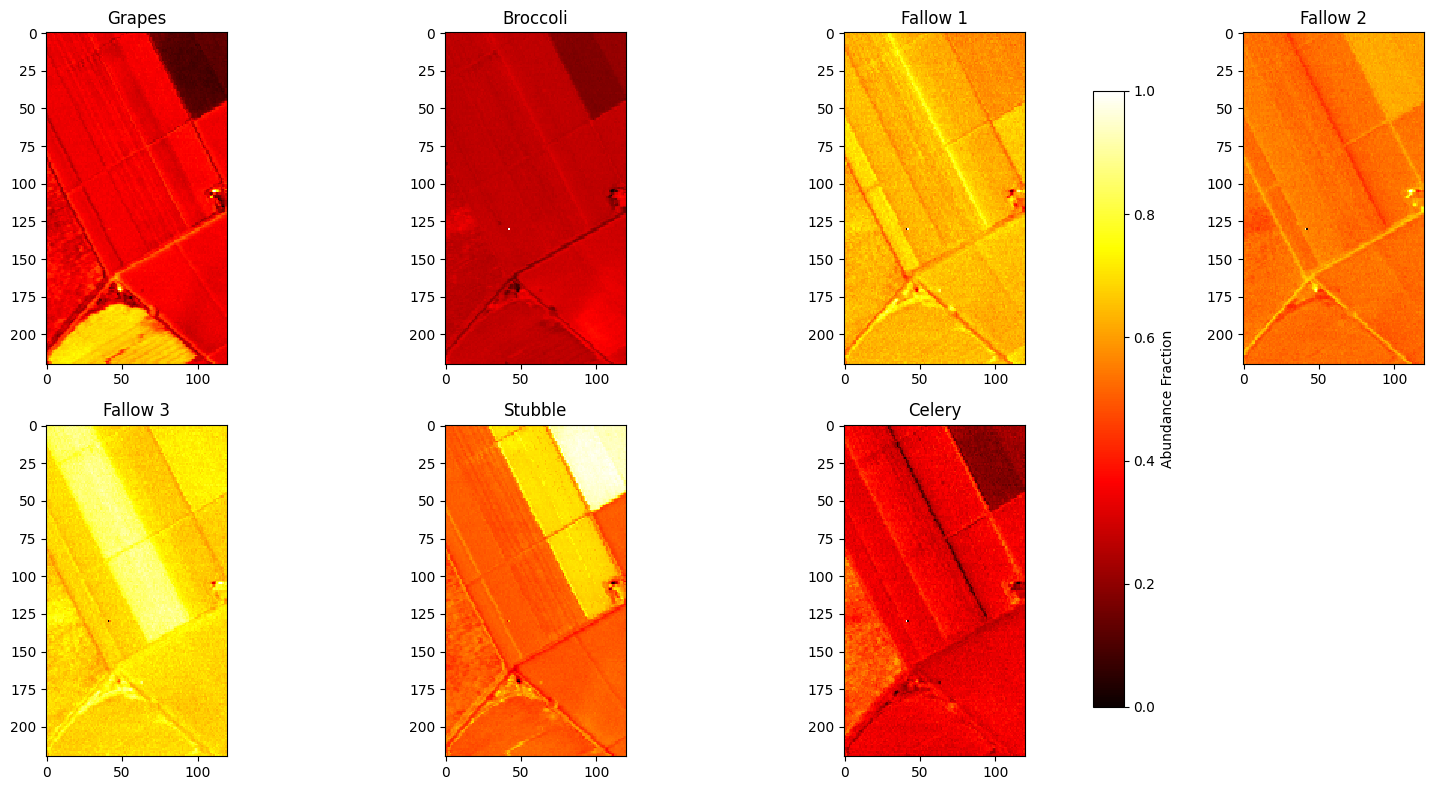

In [11]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable


fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Abundance map for each material
abundance_maps = [theta_hat_2[:, :, i] for i in range(7)]

# Plot abundance maps for each material
titles = ['Grapes', 'Broccoli', 'Fallow 1', 'Fallow 2', 'Fallow 3', 'Stubble', 'Celery']
for i, ax in enumerate(axes.flatten()):
    if i < len(abundance_maps):
        im = ax.imshow(abundance_maps[i], cmap='hot', interpolation='nearest')
        ax.set_title(titles[i])
        ax.set_aspect('equal')  # Equal aspect ratio for better visualization
    else:
        ax.axis('off')  # hide empty subplot

# Normalize colorbar with range 0 to 1
norm = plt.Normalize(vmin=0, vmax=1)  
sm = ScalarMappable(cmap='hot', norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=axes, label='Abundance Fraction')

plt.tight_layout()
plt.show()


## 3) Last squares imposing the non-negativity constraint 

In [12]:
import numpy as np
from scipy.optimize import nnls


theta_hat_3 = np.zeros((HSI.shape[0], HSI.shape[1], 7), dtype=np.float64)

for i in range(HSI.shape[0]):
    for j in range(HSI.shape[1]):
        X = endmembers
        y = HSI[i, j, :]

        
        theta_hat_3[i, j], _ = nnls(X, y)

In [13]:
y_pred_3=np.zeros((HSI.shape), dtype=np.float64)

for band in range(y_pred_3.shape[2]):
    for i in range(y_pred_3.shape[0]):
       for j in range(y_pred_3.shape[1]):
        y_pred_3[i,j,band]=(X @ theta_hat_3[i,j])[band]

In [14]:
rec_error_3=0
diff_square_3=0
cnt_3=0

for i in range(HSI.shape[0]):
    for j in range(HSI.shape[1]):
        for k in range(HSI.shape[2]):
            diff_square_3= diff_square_3 + ((HSI[i,j,k]-y_pred_3[i,j,k])**2)
            cnt_3 = cnt_3 + 1

rec_error_3 = diff_square_3/cnt_3
print('Reconstruction error for the method 3 is:',{rec_error_3})

Reconstruction error for the method 3 is: {3142.9771846114936}


C:\Users\User\AppData\Local\Temp\ipykernel_13468\2843063102.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


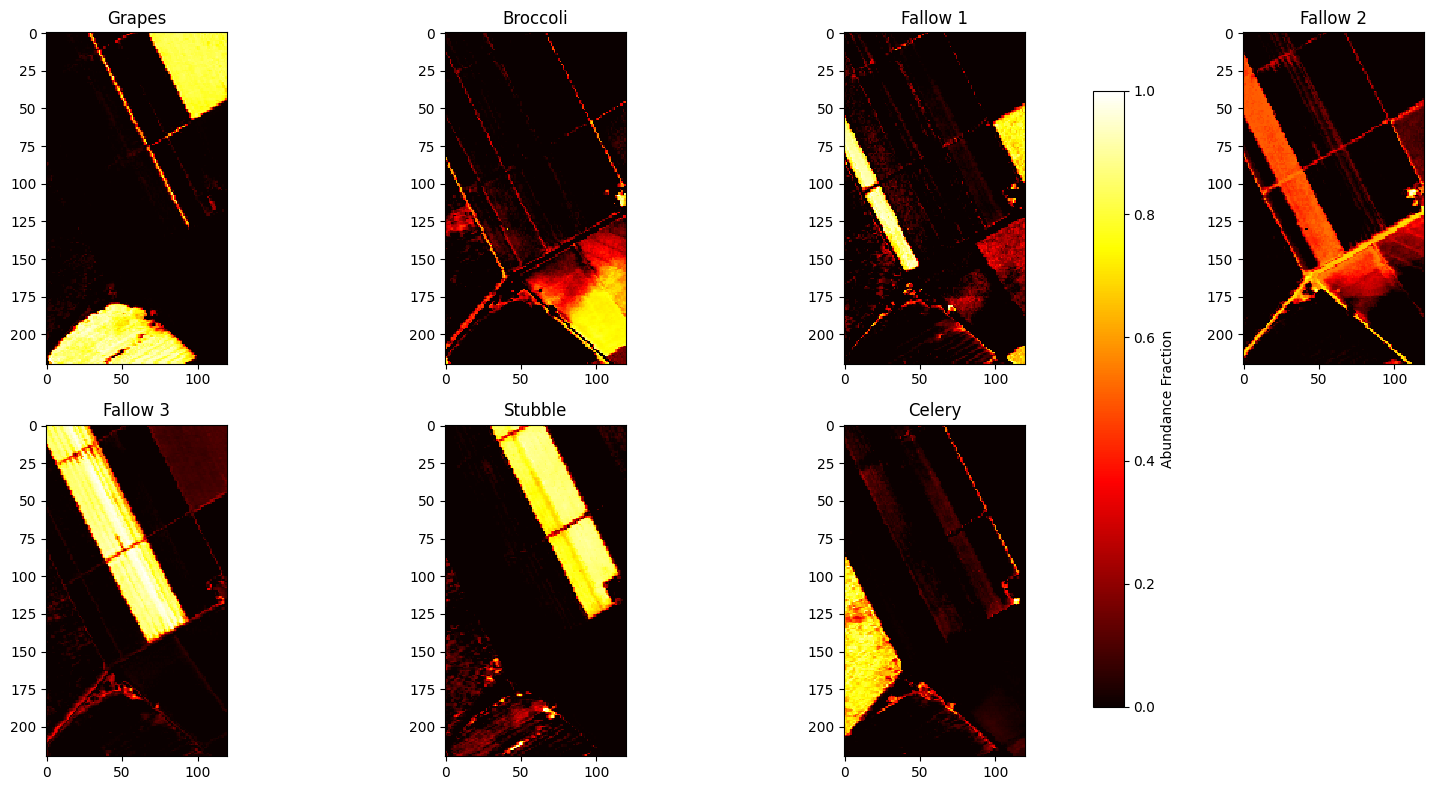

In [15]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable


fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Abundance map for each material
abundance_maps = [theta_hat_3[:, :, i] for i in range(7)]

# Plot abundance maps for each material
titles = ['Grapes', 'Broccoli', 'Fallow 1', 'Fallow 2', 'Fallow 3', 'Stubble', 'Celery']
for i, ax in enumerate(axes.flatten()):
    if i < len(abundance_maps):
        im = ax.imshow(abundance_maps[i], cmap='hot', interpolation='nearest')
        ax.set_title(titles[i])
        ax.set_aspect('equal')  # Equal aspect ratio for better visualization
    else:
        ax.axis('off')  # hide empty subplot

# Normalize colorbar with range 0 to 1
norm = plt.Normalize(vmin=0, vmax=1)  
sm = ScalarMappable(cmap='hot', norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=axes, label='Abundance Fraction')

plt.tight_layout()
plt.show()


## 4) Least squares imposing both the non-negativity and the sum-to-one constraint

In [16]:
import numpy as np
from scipy.optimize import nnls

# Initialize theta_hat_4 with the correct shape and data type
theta_hat_4 = np.zeros((HSI.shape[0], HSI.shape[1], 7), dtype=np.float64)

# Define the vector of ones
ones_vector = np.ones((7,))

for i in range(HSI.shape[0]):
    for j in range(HSI.shape[1]):
        X = endmembers
        y = HSI[i, j, :]


        theta_hat_4[i, j], _ = nnls(X, y)

# Normalize theta_hat_4 to satisfy the sum-to-one constraint
theta_hat_4_normalized = theta_hat_4 / np.sum(theta_hat_4, axis=-1, keepdims=True)


theta_hat_4 = theta_hat_4_normalized



In [17]:
y_pred_4=np.zeros((HSI.shape), dtype=np.float64)

for band in range(y_pred_4.shape[2]):
    for i in range(y_pred_4.shape[0]):
       for j in range(y_pred_4.shape[1]):
        y_pred_4[i,j,band]=(X @ theta_hat_4[i,j])[band]

In [18]:
rec_error_4=0
diff_square_4=0
cnt_4=0

for i in range(HSI.shape[0]):
    for j in range(HSI.shape[1]):
        for k in range(HSI.shape[2]):
            diff_square_4= diff_square_4 + ((HSI[i,j,k]-y_pred_4[i,j,k])**2)
            cnt_4 = cnt_4 + 1

rec_error_4 = diff_square_4/cnt_4
print('Reconstruction error for the method 4 is:',{rec_error_4})

Reconstruction error for the method 4 is: {17186.743876765624}


C:\Users\User\AppData\Local\Temp\ipykernel_13468\2713858826.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


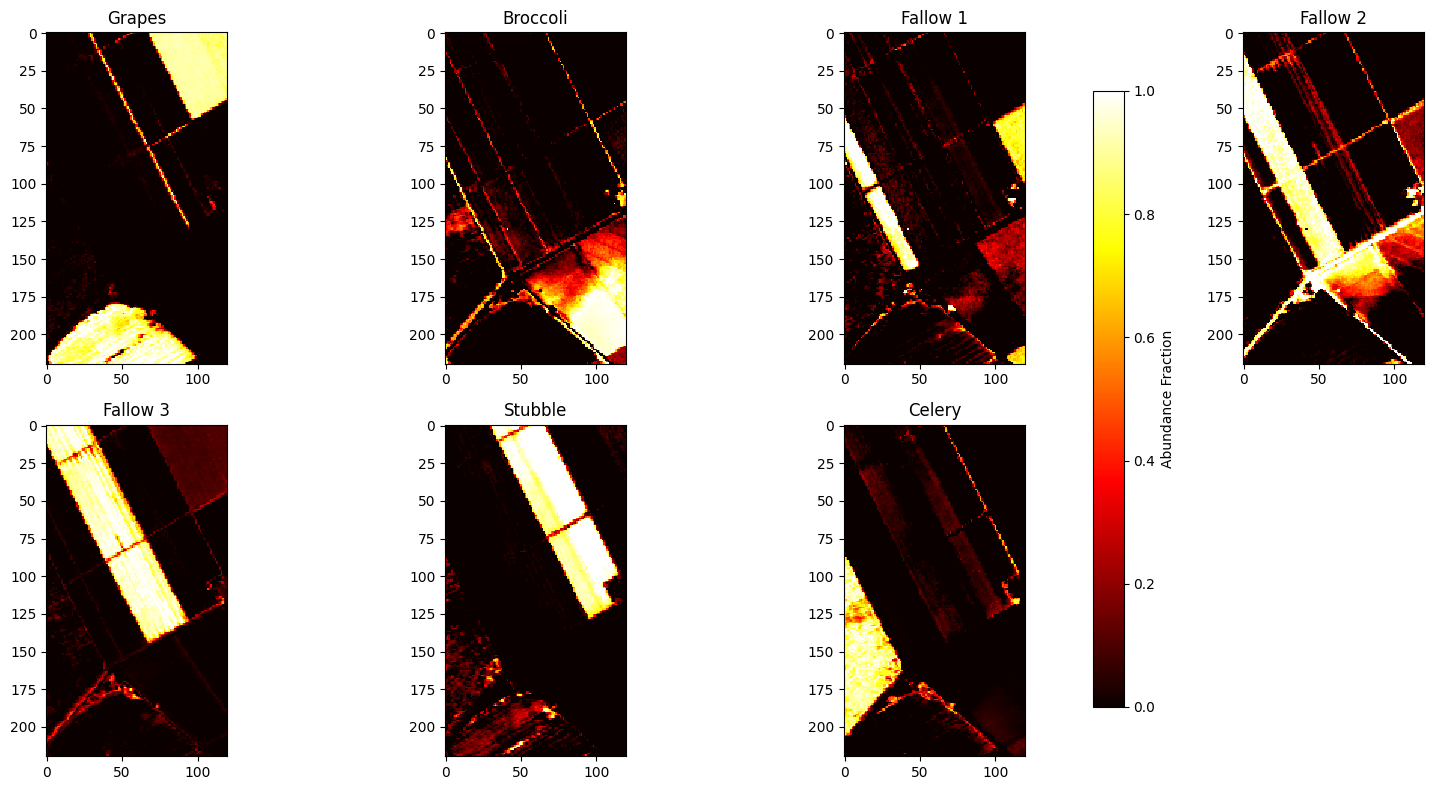

In [19]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable


fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Abundance map for each material
abundance_maps = [theta_hat_4[:, :, i] for i in range(7)]

# Plot abundance maps for each material
titles = ['Grapes', 'Broccoli', 'Fallow 1', 'Fallow 2', 'Fallow 3', 'Stubble', 'Celery']
for i, ax in enumerate(axes.flatten()):
    if i < len(abundance_maps):
        im = ax.imshow(abundance_maps[i], cmap='hot', interpolation='nearest')
        ax.set_title(titles[i])
        ax.set_aspect('equal')  # Equal aspect ratio for better visualization
    else:
        ax.axis('off')  # hide empty subplot

# Normalize colorbar with range 0 to 1
norm = plt.Normalize(vmin=0, vmax=1)  
sm = ScalarMappable(cmap='hot', norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=axes, label='Abundance Fraction')

plt.tight_layout()
plt.show()



## 5) LASSO

In [20]:
from sklearn.linear_model import Lasso

# Initialize theta_hat_5 with the correct shape and data type
theta_hat_5 = np.zeros((HSI.shape[0], HSI.shape[1], 7), dtype=np.float64)

# Define the Lasso regression model
lasso_model = Lasso(alpha=0.1)  # You can adjust the regularization parameter alpha as needed

for i in range(HSI.shape[0]):
    for j in range(HSI.shape[1]):
        X = endmembers
        y = HSI[i, j, :]

        # Fit the Lasso regression model
        lasso_model.fit(X, y)

        # Store the estimated parameter vector
        theta_hat_5[i, j] = lasso_model.coef_


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.963e+04, tolerance: 3.930e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+04, tolerance: 3.438e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

In [21]:
y_pred_5=np.zeros((HSI.shape), dtype=np.float64)

for band in range(y_pred_5.shape[2]):
    for i in range(y_pred_5.shape[0]):
       for j in range(y_pred_5.shape[1]):
        y_pred_5[i,j,band]=(X @ theta_hat_5[i,j])[band]

In [22]:
rec_error_5=0
diff_square_5=0
cnt_5=0

for i in range(HSI.shape[0]):
    for j in range(HSI.shape[1]):
        for k in range(HSI.shape[2]):
            diff_square_5= diff_square_5 + ((HSI[i,j,k]-y_pred_5[i,j,k])**2)
            cnt_5 = cnt_5 + 1

rec_error_5 = diff_square_5/cnt_5
print('Reconstruction error for the LASSO method is:',{rec_error_5})

Reconstruction error for the LASSO method is: {1339.8756209842957}


C:\Users\User\AppData\Local\Temp\ipykernel_13468\233581890.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


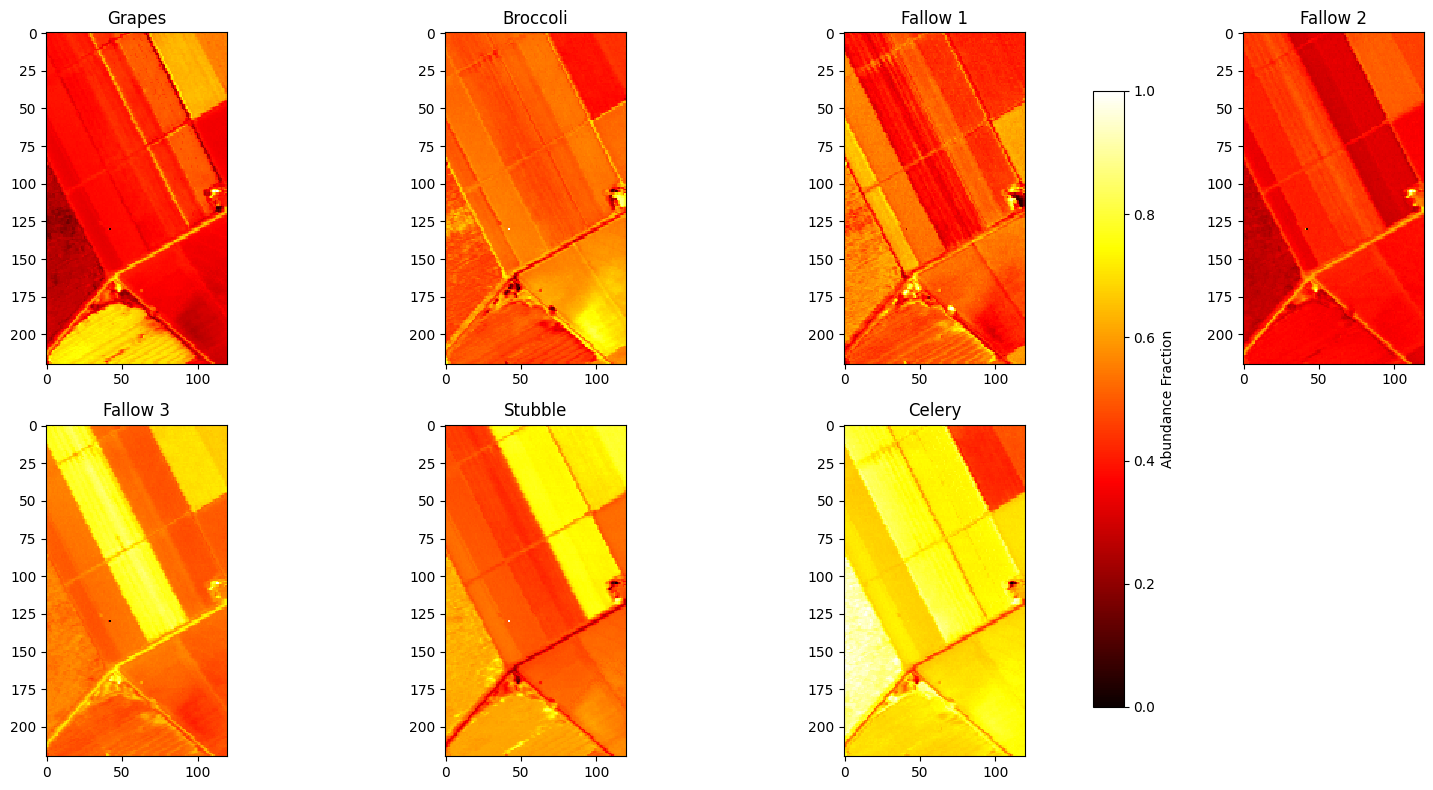

In [23]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable


fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Abundance map for each material
abundance_maps = [theta_hat_5[:, :, i] for i in range(7)]

# Plot abundance maps for each material
titles = ['Grapes', 'Broccoli', 'Fallow 1', 'Fallow 2', 'Fallow 3', 'Stubble', 'Celery']
for i, ax in enumerate(axes.flatten()):
    if i < len(abundance_maps):
        im = ax.imshow(abundance_maps[i], cmap='hot', interpolation='nearest')
        ax.set_title(titles[i])
        ax.set_aspect('equal')  # Equal aspect ratio for better visualization
    else:
        ax.axis('off')  # hide empty subplot

# Normalize colorbar with range 0 to 1
norm = plt.Normalize(vmin=0, vmax=1)  
sm = ScalarMappable(cmap='hot', norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=axes, label='Abundance Fraction')

plt.tight_layout()
plt.show()



## Comments

The simpler methods such as Least Square Error fail to provide accurate abundance maps for each material in hyperspectral imaging data. Despite their small reconstruction error, these methods can produce sub-optimal results in terms of distinguishing the contribution of individual materials within a mixed pixel. On the other hand methods that impose constraints on the abundance vector tend to produce clearer abundance maps. Although constrained methods may have a higher reconstruction error than the other methods, these methods better capture the underlying physical properties of the materials. This is clear from the results of reconstruction errors and the respective abundance maps provided above for each method.

# Part 2

## Preprocessing

In [24]:
import numpy as np
import pandas as pd



# Reshape the HSI array to have shape (220*120, 204)
HSI_reshaped = HSI.reshape(-1, HSI.shape[-1])

# Create row and column index arrays
row_indices, col_indices = np.indices(HSI.shape[:2])
row_indices = row_indices.reshape(-1)
col_indices = col_indices.reshape(-1)

# Create a DataFrame from the reshaped HSI array
HSI_df = pd.DataFrame(HSI_reshaped)

# Add row and column index columns to the DataFrame
HSI_df['Row'] = row_indices
HSI_df['Column'] = col_indices

# Print the DataFrame
print(HSI_df.head())


     0    1    2     3     4     5     6     7     8     9  ...  196  197  \
0  369  579  866  1388  1763  1877  1817  2071  2400  2538  ...  124   97   
1  369  495  735  1388  1733  1877  1837  2088  2444  2551  ...  114   99   
2  369  495  866  1346  1792  1900  1875  2121  2458  2590  ...  120  101   
3  298  579  801  1388  1763  1900  1837  2071  2415  2512  ...  118   99   
4  441  663  801  1388  1733  1855  1817  2039  2356  2473  ...  112   91   

   198  199  200  201  202  203  Row  Column  
0   58   87   55   31    9   15    0       0  
1   64   83   63   33   13   15    0       1  
2   58   83   53   33   11   19    0       2  
3   60   85   61   29    9   21    0       3  
4   58   83   51   29   11   15    0       4  

[5 rows x 206 columns]


In [25]:
import numpy as np
import pandas as pd



# Reshape the labels array to have shape (220*120,)
labels_reshaped = labels.reshape(-1)

# Create row and column index arrays
row_indices, col_indices = np.indices(labels.shape)
row_indices = row_indices.reshape(-1)
col_indices = col_indices.reshape(-1)

# Create a DataFrame from the reshaped labels array
labels_df = pd.DataFrame(labels_reshaped, columns=['Label'])

# Add row and column index columns to the DataFrame
# labels_df['Row'] = row_indices
# labels_df['Column'] = col_indices

# Print the DataFrame
print(labels_df.head())


   Label
0      0
1      0
2      0
3      0
4      0


In [26]:
df_final = pd.concat([HSI_df, labels_df], axis=1)

In [27]:
df_final.head()

0    1    2     3     4     5     6     7     8     9  ...  197  198  \
0  369  579  866  1388  1763  1877  1817  2071  2400  2538  ...   97   58   
1  369  495  735  1388  1733  1877  1837  2088  2444  2551  ...   99   64   
2  369  495  866  1346  1792  1900  1875  2121  2458  2590  ...  101   58   
3  298  579  801  1388  1763  1900  1837  2071  2415  2512  ...   99   60   
4  441  663  801  1388  1733  1855  1817  2039  2356  2473  ...   91   58   

   199  200  201  202  203  Row  Column  Label  
0   87   55   31    9   15    0       0      0  
1   83   63   33   13   15    0       1      0  
2   83   53   33   11   19    0       2      0  
3   85   61   29    9   21    0       3      0  
4   83   51   29   11   15    0       4      0  

[5 rows x 207 columns]

In [28]:
#keep only non zero pixels

df_final = df_final[df_final['Label'] != 0]

In [29]:
df_final['Label'].value_counts()

Label
6    3953
7    3579
1    2262
2    2187
5    2162
3    1957
4     829
Name: count, dtype: int64

In [30]:
#Create Train and Test set

Training_df=df_final
Test_df=df_final

for i in range(Training_Set.shape[0]):
    for j in range(Training_Set.shape[1]):
        if (Training_Set[i,j]==0):
            Training_df = Training_df.drop(Training_df[(Training_df['Row'] == i) & (Training_df['Column'] == j)].index)



for i in range(Test_Set.shape[0]):
    for j in range(Test_Set.shape[1]):
        if (Test_Set[i,j]==0):
            Test_df = Test_df.drop(Test_df[(Test_df['Row'] == i) & (Test_df['Column'] == j)].index)            

In [31]:
#HSI_df[(HSI_df['Row']==150) & (HSI_df['Column']==30)]

## naïve Bayes classifier

In [32]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np




X = df_final.drop(['Row','Column','Label'],axis=1)  
y = df_final['Label']  

# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)


errors = []

# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = nb_model.predict(X_test)
    
    error = 1 - accuracy_score(y_test, y_pred)
    
    errors.append(error)

#mean and standard deviation of errors
mean_error = np.mean(errors)
std_error = np.std(errors)


print("Mean Error:", mean_error)
print("Standard Deviation of Error:", std_error)


Mean Error: 0.01884330416301865
Standard Deviation of Error: 0.0018186501799892533


Accuracy:  0.9813327032136105


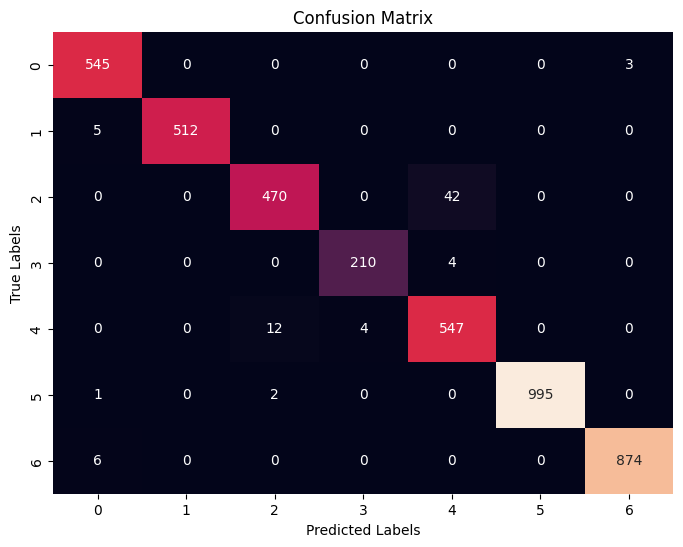

In [33]:
from sklearn.metrics import confusion_matrix


X_train = Training_df.drop(['Row','Column','Label'],axis=1)  
X_test = Test_df.drop(['Row','Column','Label'],axis=1) 
y_train = Training_df['Label']  
y_test = Test_df['Label'] 

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
    
# Predict on the test set
y_pred = nb_model.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: ",accuracy_score(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## k-nearest neighbor classifier

In [34]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np


X = df_final.drop(['Row', 'Column', 'Label'], axis=1).to_numpy()  # Convert to array
y = df_final['Label'].values  # Convert to array

# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)

errors = []

# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]  
    y_train, y_test = y[train_index], y[test_index]  
    
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = knn_model.predict(X_test)
    
    error = 1 - accuracy_score(y_test, y_pred)
    
    errors.append(error)

# Calculate mean and standard deviation of errors
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Mean Error:", mean_error)
print("Standard Deviation of Error:", std_error)


Mean Error: 0.0041349165455309535
Standard Deviation of Error: 0.0010891372174615197


Accuracy:  0.9959829867674859


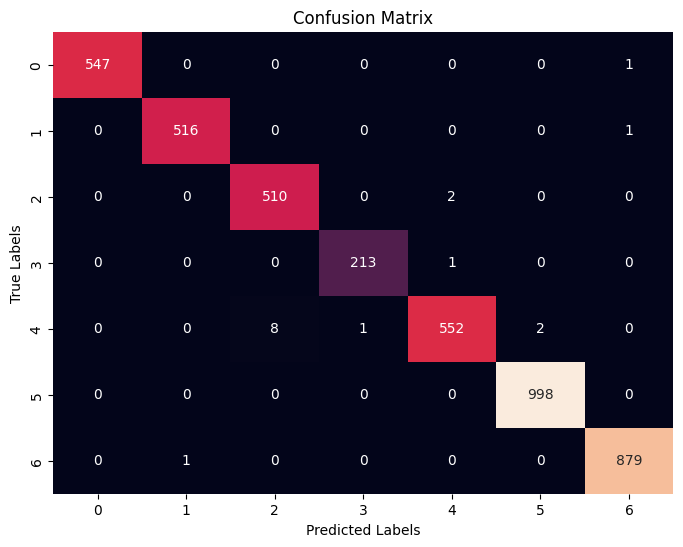

In [35]:
from sklearn.metrics import confusion_matrix


X_train = Training_df.drop(['Row','Column','Label'],axis=1)  
X_test = Test_df.drop(['Row','Column','Label'],axis=1) 
y_train = Training_df['Label']  
y_test = Test_df['Label'] 

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
    
# Predict on the test set
y_pred = knn_model.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: ",accuracy_score(y_test, y_pred))


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Bayesian classifier

In [36]:
import numpy as np
from scipy.stats import multivariate_normal

class custom_BayesClassifier:
    def __init__(self):
        self.classes = None
        self.class_prior = None
        self.class_mean = None
        self.class_covariance = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_prior = np.zeros(len(self.classes))
        self.class_mean = {}
        self.class_covariance = {}
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_prior[idx] = len(X_c) / len(X)
            self.class_mean[c] = np.mean(X_c, axis=0)
            self.class_covariance[c] = np.cov(X_c.T)
    
    def probabilities_prediction(self, X):
        probabilities = []
        for c in self.classes:
            mean = self.class_mean[c]
            cov = self.class_covariance[c]
            prior = self.class_prior[c == self.classes]
            likelihood = multivariate_normal.pdf(X, mean=mean, cov=cov)
            probabilities.append(likelihood * prior)
        probabilities = np.array(probabilities).T
        return probabilities / np.sum(probabilities, axis=1, keepdims=True)
    
    def predict(self, X):
        probabilities = self.probabilities_prediction(X)
        return self.classes[np.argmax(probabilities, axis=1)]
    



In [37]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np

# np.seterr(divide='ignore', invalid='ignore')


X = df_final.drop(['Row','Column','Label'],axis=1)  
y = df_final['Label']  

# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)


errors = []

# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    bayes_classifier = custom_BayesClassifier()
    bayes_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = bayes_classifier.predict(X_test)
    
    error = 1 - accuracy_score(y_test, y_pred)
    
    errors.append(error)

#mean and standard deviation of errors
mean_error = np.mean(errors)
std_error = np.std(errors)


print("Mean Error:", mean_error)
print("Standard Deviation of Error:", std_error)

C:\Users\User\AppData\Local\Temp\ipykernel_13468\3528190505.py:32: RuntimeWarning: invalid value encountered in divide
  return probabilities / np.sum(probabilities, axis=1, keepdims=True)
C:\Users\User\AppData\Local\Temp\ipykernel_13468\3528190505.py:32: RuntimeWarning: invalid value encountered in divide
  return probabilities / np.sum(probabilities, axis=1, keepdims=True)
C:\Users\User\AppData\Local\Temp\ipykernel_13468\3528190505.py:32: RuntimeWarning: invalid value encountered in divide
  return probabilities / np.sum(probabilities, axis=1, keepdims=True)
C:\Users\User\AppData\Local\Temp\ipykernel_13468\3528190505.py:32: RuntimeWarning: invalid value encountered in divide
  return probabilities / np.sum(probabilities, axis=1, keepdims=True)
C:\Users\User\AppData\Local\Temp\ipykernel_13468\3528190505.py:32: RuntimeWarning: invalid value encountered in divide
  return probabilities / np.sum(probabilities, axis=1, keepdims=True)
C:\Users\User\AppData\Local\Temp\ipykernel_13468\352819

Mean Error: 0.004489386836912945
Standard Deviation of Error: 0.0012448226432151808


C:\Users\User\AppData\Local\Temp\ipykernel_13468\3528190505.py:32: RuntimeWarning: invalid value encountered in divide
  return probabilities / np.sum(probabilities, axis=1, keepdims=True)


C:\Users\User\AppData\Local\Temp\ipykernel_13468\3528190505.py:32: RuntimeWarning: invalid value encountered in divide
  return probabilities / np.sum(probabilities, axis=1, keepdims=True)


Accuracy:  0.9761342155009451


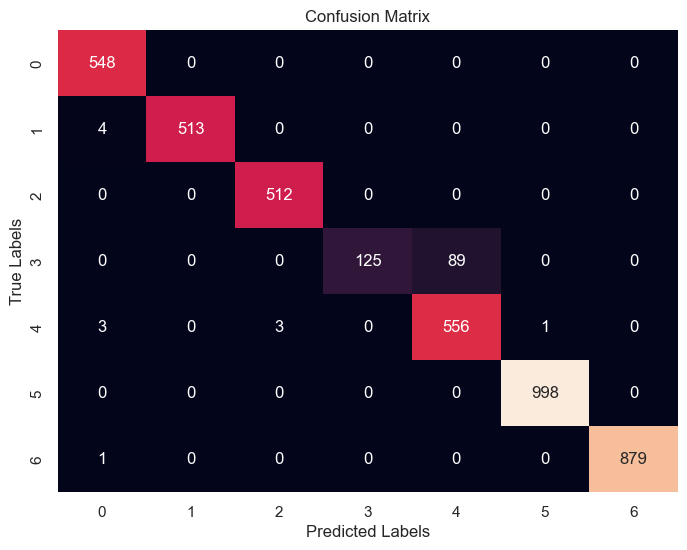

In [38]:
from sklearn.metrics import confusion_matrix


X_train = Training_df.drop(['Row','Column','Label'],axis=1)  
X_test = Test_df.drop(['Row','Column','Label'],axis=1) 
y_train = Training_df['Label']  
y_test = Test_df['Label'] 

bayes_classifier_classifier = custom_BayesClassifier()
bayes_classifier_classifier.fit(X_train, y_train)
    
# Predict on the test set
y_pred = bayes_classifier_classifier.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: ",accuracy_score(y_test, y_pred))
sns.set(style="whitegrid")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Euclidian distance classifier

In [40]:
import numpy as np

class EuclideanDistanceClassifier:
    def __init__(self):
        self.class_means = {}
    
    def fit(self, X_train, y_train):
        # Calculate mean for each class
        for class_label in np.unique(y_train):
            class_data = X_train[y_train == class_label]
            class_mean = class_data.mean(axis=0)
            self.class_means[class_label] = class_mean
    
    def _calculate_distance(self, x, class_label):
        class_mean = self.class_means[class_label]
        return np.linalg.norm(x - class_mean)
    
    def predict(self, X_test):
        predictions = []
        for _, sample in X_test.iterrows():
            min_distance = float('inf')
            predicted_class = None
            for class_label in self.class_means:
                distance = self._calculate_distance(sample, class_label)
                if distance < min_distance:
                    min_distance = distance
                    predicted_class = class_label
            predictions.append(predicted_class)
        return predictions



In [41]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np




X = df_final.drop(['Row','Column','Label'],axis=1)  
y = df_final['Label']  

# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)


errors = []

# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    euclidean_classifier = EuclideanDistanceClassifier()
    euclidean_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = euclidean_classifier.predict(X_test)
    
    error = 1 - accuracy_score(y_test, y_pred)
    
    errors.append(error)

#mean and standard deviation of errors
mean_error = np.mean(errors)
std_error = np.std(errors)


print("Mean Error:", mean_error)
print("Standard Deviation of Error:", std_error)

Mean Error: 0.04270766569059918
Standard Deviation of Error: 0.0031021703304950333


Accuracy:  0.9591209829867675


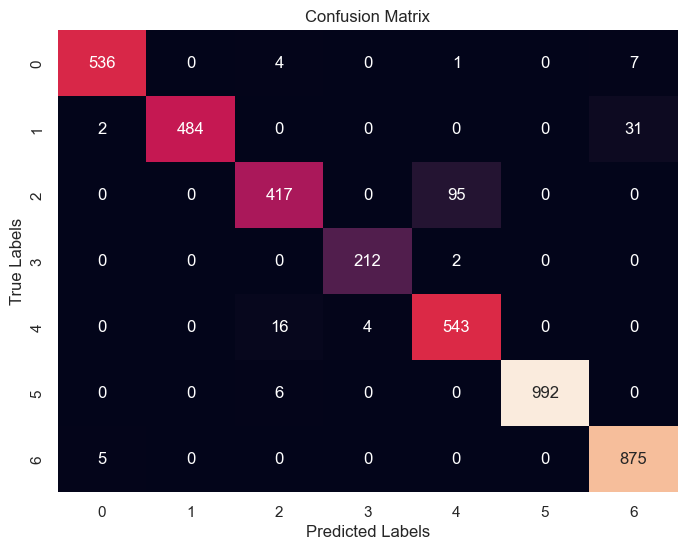

In [42]:
from sklearn.metrics import confusion_matrix


X_train = Training_df.drop(['Row','Column','Label'],axis=1)  
X_test = Test_df.drop(['Row','Column','Label'],axis=1) 
y_train = Training_df['Label']  
y_test = Test_df['Label'] 

euclidean_classifier = EuclideanDistanceClassifier()
euclidean_classifier.fit(X_train, y_train)
    
# Predict on the test set
y_pred = euclidean_classifier.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy: ",accuracy_score(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Comments

* Naive Bayes Classifier
  * It provides a relatively low mean error and standard deviation of error, indicating consistent performance across the cross-validation folds.
  * The accuracy of approximately 98.13% on the whole training set suggests strong overall performance.
  * The confusion matrix has a few elements off the diagonal but in general most of cases have been classified correcltly.

* k-Nearest Neighbor (kNN) Classifier  
  * It demonstrates the lowest mean error and standard deviation of error among all classifiers, indicating high precision and consistency in classification.
  * The accuracy of approximately 99.6% on the whole training set is the highest among the classifiers, indicating excellent classification performance.
  * The confusion matrix shows a higher number of elements along the diagonal, suggesting that the kNN classifier has effectively classified instances into their respective classes.

* Bayesian Classifier
  * It shows a low mean error and standard deviation of error, indicating stable performance across cross-validation folds. 
  * The accuracy of approximately 97.61% on the whole training set is slightly lower compared to kNN but still relatively high.
  * The confusion matrix has slightly more elements off the diagonal than the other 2 classifiers

* Euclidean Distance Classifier
  * It has the highest mean error and standard deviation of error among all classifiers, indicating less consistent performance.
  * The accuracy of approximately 95.91% on the whole training set is lower compared to other classifiers, suggesting comparatively weaker performance
  * The confusion matrix indicates more elements off the diagonal compared to the other classifiers, indicating misclassifications or confusion among classes.



 
Overall the kNN classifier seems to be the top classifier in terms of performance based on the above metrics
with the lowest error rates and highest accuracy.


# Part 3

The results of spectral unmixing and classification methods are closely related because they both help to make sense of hyperspectral images, but they work differently.
Spectral unmixing breaks down mixed pixel spectra into individual materials and their amounts in each pixel. This tells us what's in each part of the image.
The maps it produces, showing how much of each material is present, can be used later to help classify the image. These maps give detailed information about what's in each pixel.
Classification sorts pixels or areas of an image into categories based on their spectral patterns or other features. It helps identify different things in the image.
The accuracy of classification can be better when using detailed information from spectral unmixing. This detailed information gives the classifier better clues about what's in each pixel.

In simple terms, spectral unmixing helps us understand what materials are in the image, and this information can make the classification process more accurate by providing better clues about what each part of the image contains.